# Analysis of our user study

In this notebook we provide the code that was used to obtain the results from the user study shown in our paper.

In [7]:
import pandas as pd
import json
from pandas import DataFrame
import math

import torch
import pickle
import matplotlib.pyplot as plt
from concept_reader import ConceptExemplar, read_concepts, Concept
import torchvision.transforms as transforms
#import clip
from PIL import Image
import numpy
from collections import OrderedDict
from tqdm import tqdm
import json
import cv2
import pandas as pd
from pandas import DataFrame

import itertools

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()


import gensim
from gensim.models import CoherenceModel, KeyedVectors
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel

device = "cuda:1" if torch.cuda.is_available() else "cpu"

## Data loading and preparation

Load the user study data files, that contain the annotations for the concept examples.
We collected 2600 human assessments of visual concepts from students for this experiment. They data contains a meaning annotated for the concept in form of a word and a numerical rating of the fit of the description in the range 0 (not at all) to 3 (very well).

In [13]:
# Load the data
full_list = []
for i in range(10):
    with open(f"data/user_study/annotations{i+1:02d}.json") as file: # Ignore the syntax highlighting, this is correct.
        mylist = json.load(file)
        #print(len(mylist))
        full_list.extend(mylist)
mylist = full_list
print("Loaded", len(mylist), "ground truth concept ratings.")

Loaded 2600 ground truth concept ratings.


Some post-processing of the results. 
Within our dataset, we annotated which algorithm provided the words chosen by the user, to study which method produced the best-fitting descriptions. However, sometimes there were singular and plural names of the same words provided, which we fuse in postprocessing.
If the corresponding word was chosen, both algorithms obtained a point.

In [133]:
process = words_lists[2]
for word in process:
    for item in word["word_list"]:
        item["score"] = -1*item["score"]

In [14]:
# Merge singular and plural words, e.g. "door", "doors". 
# The lists of algorithms that provided these words will be fused as well.

# List of annotations (meanings) for the concepts provided by our annotation modules (OC, JVL, JVL with cropping)
word_files = {0: "data/user_study/oc_words.json", 1: "data/user_study/jvl_words_mse_10kwords.json", 2: "data/user_study/jvl_crop_words_mse_10kwords.json"}

words_lists = {k: json.load(open(v, "r")) for k, v in word_files.items()}

def fuse_wordlists(file_name, infile_idx, items):
    """ Return a list of the words from all algorithms. """
    
    num_words = 4 # Max number of words displayed
    word_dict = {}
    for alg_id, v in words_lists.items():
        for item in v:
            if item["source_file"] == file_name and item["source_id"] == infile_idx:
                num_items = 0
                for witem in item["word_list"]:
                    if num_items >= num_words:
                        break   
                    if witem["word"] in word_dict:
                        word_dict[witem["word"]].append(alg_id)
                    else:
                        word_dict[witem["word"]] = [alg_id]
                    num_items += 1
    own_entries = find_all_own_words(file_name, infile_idx, items)
    for e in own_entries:
        if e in word_dict:
            word_dict[e].append(3)
        else:
            word_dict[e] = [3]
        
    unmerged_list =  [(k,v) for k, v in word_dict.items()]
    merged_list = [k for (k,v) in unmerged_list]
    
    for word in merged_list: # Remove plural if it is also in list.
        if word + "s" in merged_list:
            merged_list.remove(word + "s")

    return unmerged_list, merged_list
   
def find_all_own_words(source_file, source_id, item_list):
    ret_list = []
    for item in mylist:
        if item["source_file"] == source_file and item["source_id"] == source_id:
            if item["description_algorithm"] == [3]: # 3 means user entry
                ret_list.append(item["description"])
    return ret_list

for item in mylist:
    if len(item["description_algorithm"]) == 0:
        item["description_algorithm"] =  [3]
        
for item in mylist:
    corresponding_words, merged_list = fuse_wordlists(item["source_file"], item["source_id"], mylist)
    if item["description"][-1] == "s": # Try removing the plural
        for word, alg in corresponding_words:
            if word == item["description"][:-1]:
                #print(word, item["description"])
                myset = set(item["description_algorithm"])
                myset.update(alg)
                item["description_algorithm"] = list(myset)
                item["description"] = item["description"][:-1] # Remove plural.
    else: # Try mergin with the plural
        for word, alg in corresponding_words:
            if word == item["description"]+  "s":
                #print(word, item["description"])
                myset = set(item["description_algorithm"])
                myset.update(alg)
                item["description_algorithm"] = list(myset)
    #print(item["source_file"], item["source_id"], item)
    try:
        item["description_idx"] = merged_list.index(item["description"])
    except ValueError:
        item["description_idx"] = 0
        
    item["num_word_choices"] = len(merged_list)

Load data in to a ``pandas.Dataframe``. Also load the Cross-Validation Splits (the splits we initially used were generated randomly. For reproducability, we stored them in an additional file and load them).

In [15]:
# Load Dataframe and the Cross-Validation Splits (the splits we initially used were generated randomly. For re)
data_frame = DataFrame.from_dict(mylist)

split_dict = {} # Map (source_file, source_id) -> is_test
import csv
with open('data/user_study/split.csv', 'r', newline='\r\n') as incsv:
    reader = csv.reader(incsv)
    first_row = True
    for row in reader:
        if first_row:
            first_row = False
            continue
        split_dict[(row[0], int(row[1]))] = int(row[2])

#print(split_dict)

is_test_list = []
for i in range(len(data_frame)):
    is_test_list.append(split_dict[(data_frame["source_file"].iloc[i], data_frame["source_id"].iloc[i])])
x = pd.Series(is_test_list, name="fold")
data_frame["fold"] = x


In [16]:
data_frame

,source_file,source_id,rating,rating_num,description,description_algorithm,description_idx,num_word_choices,fold
0,places365_kMeans,21,very well,3,tower,"[0, 1, 2]",2,7,0
1,awa_mixin10,7,not at all,0,a,[3],11,13,2
2,awa_kMeans,10,mostly well,2,background,[3],10,13,7
3,places365_mixin5,17,to some extend,1,monitor,[3],9,10,3
4,places365_kMeans,40,very well,3,water,[0],0,8,5
...,...,...,...,...,...,...,...,...,...
2595,places365_mixin10,18,not at all,0,0,[3],10,11,4
2596,awa_mixin5,16,to some extend,1,nature,[3],11,12,0
2597,awa_Shap,20,mostly well,2,biodiversity,[2],11,16,7
2598,places365_Shap,0,mostly well,2,dinner_table,"[1, 2]",6,9,5


Description of the columns:

* ``source_file``: Source of the concept of the form ``<dataset>_<algorithm>``.
* ``source_id``: Running number in the concept file. source_file and source_id together form a unique identifier for a specific concept. In total, there are 260 concepts.
* ``rating``: Rating assigned by the annotator in text form
* ``rating_num``: Rating converted to a numerical score. 
* ``description``: Single-word description assigned to the concept by the user.
* ``description_algorithm``: Which algorithm provided the description. The user was offered a choice of words by the annotation modules to choose from. If they picked one of these choices, this field indicates which algorithm came up with this word. 0 means the word was entered manually.
* ``decription_idx``: Numeric index of the word out of the choices. Same words have the same index (in the same concept).
* ``num_word_choice``: Number of words that were given as a choice for the rater + numer of freely chosen words (range of ``description_idx``).
* ``fold`` cross-validation fold number (0-9)

Example: Show all ratings for a specific conept.

In [17]:
data_frame[(data_frame["source_id"]==8) & (data_frame["source_file"]=="awa_Shap")]

,source_file,source_id,rating,rating_num,description,description_algorithm,description_idx,num_word_choices,fold
46,awa_Shap,8,to some extend,1,mane,"[1, 2]",4,11,0
404,awa_Shap,8,not at all,0,wall,[0],0,11,0
702,awa_Shap,8,to some extend,1,fur,[2],8,11,0
929,awa_Shap,8,mostly well,2,fur,[2],8,11,0
1162,awa_Shap,8,mostly well,2,fur,[2],8,11,0
1465,awa_Shap,8,mostly well,2,mane,"[1, 2]",4,11,0
1679,awa_Shap,8,mostly well,2,mane,"[1, 2]",4,11,0
1876,awa_Shap,8,not at all,0,hairy,[1],7,11,0
2196,awa_Shap,8,mostly well,2,fur,[2],8,11,0
2485,awa_Shap,8,mostly well,2,animals,[3],10,11,0


In [18]:
## Evaluate the description algorithms
data_frame["description_algorithm"] = data_frame["description_algorithm"].astype(str)
data_frame_filtered = data_frame[data_frame["rating_num"] >= 1]
all_contains = pd.concat({"Manual": data_frame_filtered["description_algorithm"].str.contains("3"), "OC": data_frame_filtered["description_algorithm"].str.contains("0"), "JVL": data_frame_filtered["description_algorithm"].str.contains("1"), "JVL (cropped images)": data_frame_filtered["description_algorithm"].str.contains("2")}, axis=1)
agg = all_contains.sum(axis=0)
agg/all_contains.shape[0]

Manual                  0.130337
OC                      0.525393
JVL                     0.365843
JVL (cropped images)    0.476404
dtype: float64

Text(0.5, 1.0, 'words chosen')

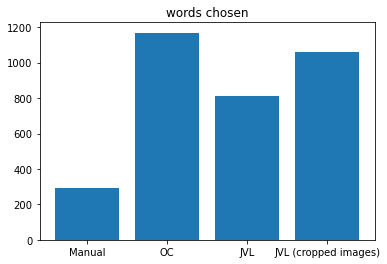

In [19]:
import matplotlib.pyplot as plt
import numpy as np
labels = agg.index.to_list()
values = agg.to_numpy()
plt.bar(np.arange(4), values)
plt.xticks(np.arange(4), labels)
plt.title("words chosen")

The words chosen by the users stem mostly from the Object Centric (OC) model, however both JVL implementations are not far behind. Common words from several models were fused (therefore the percentages do not add up to 1.)

In about 13 % of the cases, the subjects chose to use their own description instead of one proposed by the annotation modules.

Distribution of ratings:

In [22]:
data_frame[['rating', 'rating_num']].groupby(['rating']).count()

,rating_num
rating,
mostly well,1015
not at all,375
to some extend,774
very well,436


"mostly well" (2 out of 3) was the most frequently chosen rating.

Print the mean rating of each source:

In [23]:
data_frame.groupby(['source_file']).mean()[["rating_num"]]

,rating_num
source_file,
awa_Shap,1.340
awa_kMeans,1.442
awa_mixin10,0.895
awa_mixin5,1.100
places365_Shap,2.220
places365_kMeans,2.196
places365_mixin10,0.900
places365_mixin5,1.450


## Run the coherence assessors and compute correlations

In this section, we compute some of our coherence assessors and compare their results to the human ratings.

Before we can run the visual embeddings, we need to obtain the images for the concepts. Therefore, please download the respective datasets from their sources,
* Places 365 (only validation images are needed (2.2G) from http://data.csail.mit.edu/places/places365/val_large.tar)
* AwA2 https://cvml.ist.ac.at/AwA2/AwA2-data.zip (13G)
and extract them. 

Then set the following variables to the location of the datasets. Make sure the images are in subfolders of the locations passed, to the script will find them.

In [30]:
places_path = "/ssd/tobias/places365large"
awa_path = "/ssd/tobias/datasets/awa"

In [34]:
from add_images_script import add_images_to_concepts

In [35]:
ret = add_images_to_concepts("data/concepts_wo_img", [places_path, awa_path])
print("Successfully added images to", ret, "concepts")

Paths scanned. Found 116173 files.
Processed  data/concepts_wo_img/places365_mixin5/concept_7.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_11.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_17.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_16.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_4.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_10.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_9.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_18.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_14.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_1.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_3.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_12.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_13.pickle
Processed  data/concepts_wo_img/places365_mixin5/concept_19.pickle
Processed  data/concepts_wo_img/

## Assessors: Get Visual-Embeddings (VE) and Best-Aligned Meaning (BAM) Scores

In [48]:
%load_ext autoreload
%autoreload 2

In [148]:
eval_concepts = []
concept_model = ['awa_Shap', 'awa_kMeans', 'awa_mixin5', 'awa_mixin10',
                 'places365_Shap', 'places365_kMeans', 'places365_mixin5', 'places365_mixin10'] #
for m in concept_model:
    foldername = "data/concepts_wo_img/" + m
    eval_concepts.extend(read_concepts(foldername))
print(f"Loaded {len(eval_concepts)} concept examples and concept activation maps.")

Loaded 260 concept examples and concept activation maps.


In [149]:
# Name the annotation outputs
words_dictOC = words_lists[0]
words_dictJVL = words_lists[1]
words_dictJVLCrop = words_lists[2]

In [193]:
# Create a whole matrix for results of the coherence assessment modules.
# First, we test Visual Embeddings (VE) with different coherence metrics and the Best-Aligned Meaning (BAM) module with different annotators.
from coherence_assessor import BestAlignedMeaningAssessor, VisualEmbeddingsAssessor, HybridAssessor
import torchvision.models as models

use_device = "cuda:1"

model = models.resnet50(pretrained=True).to(use_device)
# Set up a dict with the names and the corresponding annotation modules.
columns = [("ve_dmin", words_dictOC, VisualEmbeddingsAssessor(device=use_device, coherence_measure = "min", cam_weighted=False, model=model)),
           ("ve_dmean", words_dictOC, VisualEmbeddingsAssessor(device=use_device, coherence_measure = "mean", cam_weighted=False, model=model)),
           ("ve_dmin_weigh", words_dictOC, VisualEmbeddingsAssessor(device=use_device, coherence_measure = "min", cam_weighted=True, model=model)),
           ("ve_dmean_weigh", words_dictOC, VisualEmbeddingsAssessor(device=use_device, coherence_measure = "mean", cam_weighted=True, model=model)),
           ("bam_jvl", words_dictJVL, BestAlignedMeaningAssessor()),
           ("bam_jvl_crop", words_dictJVLCrop, BestAlignedMeaningAssessor()),
           ("bam_oc", words_dictOC, BestAlignedMeaningAssessor()),
          ] 

In [151]:
# Some space to save results.
results_dict = {c[0]: np.zeros(len(eval_concepts)) for c in columns}            
results_dict["ground_truth"] = np.zeros(len(eval_concepts))
results_dict["folds"] = np.zeros(len(eval_concepts))

In [152]:
results_dict.keys()

dict_keys(['ve_dmin', 've_dmean', 've_dmin_weigh', 've_dmean_weigh', 'bam_jvl', 'bam_jvl_crop', 'bam_oc', 'ground_truth', 'folds'])

Load the pretrained ResNet50 for the visual embeddings and register a hook to access the latent representation

In [153]:
def get_average_score(file_name, source_id):
    selection = data_frame[(data_frame['source_file'] == file_name) & (data_frame['source_id']==source_id)] #
    return selection["rating_num"].mean()

def get_meaning_from_list(wordlist, file_name, source_id):
    for item in wordlist:
        if item["source_file"] == file_name and item["source_id"] == source_id:
            return item["word_list"]
    return None

In [154]:
get_meaning_from_list(words_dictOC, "awa_Shap", 3)

[{'word': 'head', 'score': 1.9661644970155396},
 {'word': 'ear', 'score': 1.784575711716616},
 {'word': 'grass', 'score': 1.7227018854713114},
 {'word': 'bear', 'score': 1.4485389878489097},
 {'word': 'fur', 'score': 1.0509405324383936},
 {'word': 'tree', 'score': 1.0062782881996035}]

In [155]:
source_to_idx = {} # A dictionary mapping the (source_file, source_id) -> index in the results array.
from tqdm import tqdm
for i, my_concept in tqdm(enumerate(eval_concepts)):
    # Load concept and compute CNN features
    
    results_dict["folds"][i] = split_dict[(my_concept.source_file, my_concept.source_id)]
    results_dict["ground_truth"][i] = get_average_score(my_concept.source_file, my_concept.source_id)
    
    for name, annotations, assessor_obj in columns:
        #print(name, len(annotations), assessor_obj)
        #retrieve annotations
        meaning = get_meaning_from_list(annotations, my_concept.source_file, my_concept.source_id)
        results_dict[name][i] = assessor_obj.assess(meaning, my_concept)

260it [01:54,  2.28it/s]


# Visualize the results.

In [118]:
# For nice latex figures. Skip if you are happy with normal output.
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    #"font.sans-serif": ["Helvetica"]}
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": r"\usepackage{bm,times}",
    "font.family": "times",
    # Use LaTeX default serif font.
    "font.serif": ["Times"],
    # Use specific cursive fonts.
    "font.cursive": ["Comic Neue", "Comic Sans MS"],

})

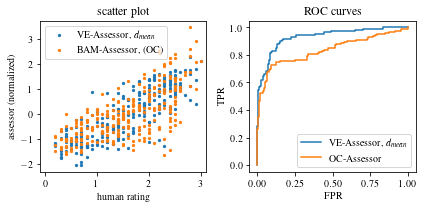

In [122]:
from sklearn import metrics
f, (ax1, ax2) = plt.subplots(1,2)
median = np.median(results_dict["ground_truth"])
ground_truth_classification = results_dict["ground_truth"] > median # Classification: larger or smaller than median
target1 = "ve_dmean_weigh"
target2 = "bam_oc"
ve_dmean = (results_dict[target1]-results_dict[target1].mean())/results_dict[target1].std()
bam_oc = (results_dict[target2]-results_dict[target2].mean())/results_dict[target2].std()

ax1.scatter(results_dict["ground_truth"], ve_dmean, 5, label=r"VE-Assessor, $d_{mean}$")
ax1.scatter(results_dict["ground_truth"], bam_oc, 5, label=r"BAM-Assessor, (OC)")

fprvi, tprvi, _ = metrics.roc_curve(ground_truth_classification, ve_dmean)
fprvs, tprvs, _ = metrics.roc_curve(ground_truth_classification, bam_oc)

ax2.plot(fprvi, tprvi, label=r"VE-Assessor, $d_{mean}$")
ax2.plot(fprvs, tprvs, label=r"OC-Assessor")
ax1.set_title("scatter plot")
ax1.set_xlabel("human rating")
ax1.set_ylabel("assessor (normalized)")
ax2.set_title("ROC curves")
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")
ax2.legend()
ax1.legend()
ax1.set_xlim([-0.1,3.1])
plt.gcf().set_size_inches(6,3)
plt.tight_layout()
plt.gcf().savefig("data_scatter.pdf")

# Run crossvalidation to compute covariance matrices and models

In [138]:
def cross_val_covariance_matrix(results_matrix, n=5):
    """ Results matrix: Output of previous processing step. The last column contains the fold indices in range [0 ... 9]
        n: number of Validation folds. n = 2,5,10
    """
    corr_mat = np.zeros((results_matrix.shape[1]-1, results_matrix.shape[1]-1, n))
    for i in range(n):
        indices = ((results_matrix[:,-1].astype(int) // (10/n)) == i)
        results_matrix_test = results_matrix[indices,:-1]
        corr_mat[:,:,i] = np.corrcoef(results_matrix_test.T)
    return corr_mat.mean(axis=2), corr_mat.std(axis=2)/math.sqrt(n)

In [140]:
# Assemble results to matrix
results_matrix = numpy.stack([v for v in results_dict.values()]).T
corr, stderr = cross_val_covariance_matrix(results_matrix, n=5)
print(corr.shape)
print("Correlations")
names = [v for v in results_dict.keys()]
compare_idx = 7 # ground truth
for clm in range(len(corr)):
    print("Correlation btw.", names[compare_idx], "/",names[clm], f"{corr[compare_idx, clm]:.03} (+-{stderr[compare_idx, clm]:.03})" )

(8, 8)
Correlations
Correlation btw. ground_truth / ve_dmin 0.562 (+-0.0342)
Correlation btw. ground_truth / ve_dmean 0.755 (+-0.0195)
Correlation btw. ground_truth / ve_dmin_weigh 0.719 (+-0.0173)
Correlation btw. ground_truth / ve_dmean_weigh 0.83 (+-0.0117)
Correlation btw. ground_truth / bam_jvl 0.392 (+-0.0234)
Correlation btw. ground_truth / bam_jvl_crop 0.365 (+-0.0242)
Correlation btw. ground_truth / bam_oc 0.696 (+-0.02)
Correlation btw. ground_truth / ground_truth 1.0 (+-3.14e-17)


# Run the Hybrid assessors (HY)

For the combined models, we compute the correlation and the accuracy that could be optained by a Logistic regression classifier, that only considers the two-class problem of predicting if a concept is rated above or below the median.


To speed up computation, we compute the scores directly from the data matrix obtained in the last step. However, we also have implemented a class ``HybridAssessor`` that could be used.

In [171]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
def cross_combined_correlation(input_matrix, n=5):
    """ Fit a Linear Regression to :-2 columns in results matrix, to predict results_matrix column -2 (contains the ground truth)
        The very last column (-1) of results matrix is supposed to contain the folds, the previous one (-2) the ground truth
        n = number of folds for crossvalidation.
    """
    corrs = np.zeros(n)
    for i in range(n):
        test_indices = ((input_matrix[:,-1].astype(int) // (10/n)) == i)
        train_indices = ~test_indices
        results_matrix_train = input_matrix[train_indices,:]
        results_matrix_test = input_matrix[test_indices,:]
        reg = LinearRegression(fit_intercept=True).fit(results_matrix_train[:,:-2], results_matrix_train[:,-2])
        pred = reg.predict(results_matrix_test[:,:-2])
        corrs[i] =  np.corrcoef(pred.flatten(), results_matrix_test[:,-2].flatten())[0,1]
        #corrs[i] = np.sum(reg.predict(results_matrix_test[:,1:])==labels_test)/len(labels_test)
    #print(corrs)
    return corrs.mean(), corrs.std()

In [172]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor
def cross_combined_accuracy(input_matrix, n=5):
    """ Fit a model to :-2 columns in results matrix, to predict results_matrix -1 (contains the ground truth)
        The very last column (-1) of results matrix is supposed to contain the folds, the previous one (-2) the ground truth
        n = number of folds for crossvalidation.
    """
    input_normalized = (input_matrix[:,:-1]-input_matrix[:,:-1].mean(axis=0))/input_matrix[:,:-1].std(axis=0)
    median = np.median(input_matrix[:, -2])
    labels = input_matrix[:, -2] > median
    
    corrs = np.zeros(n)
    for i in range(n):
        test_indices = ((input_matrix[:,-1].astype(int) // (10/n)) == i)
        train_indices = ~test_indices
        results_matrix_train = input_normalized[train_indices,:]
        results_matrix_test = input_normalized[test_indices,:]
        labels_train = labels[train_indices]
        labels_test = labels[test_indices]
        
        #print(results_matrix_train.shape, results_matrix_test.shape, len(labels_test))
        reg = LogisticRegression(fit_intercept=True).fit(results_matrix_train[:,:-2], labels_train)
        # reg = ExtraTreesRegressor(n_estimators=500).fit(results_matrix_train[:,:-2], labels_train)
        pred = reg.predict(results_matrix_test[:,:-2])>0.5
        corrs[i] = np.sum(pred==labels_test)/len(labels_test)
    return corrs.mean(), corrs.std()

## Combine the best features of all categories

We use the VE assessor, with $d_{mean}$ and combine it with the different BAM assessors.

In [173]:
def get_combined_matrix(clmlist):
    """ Combine some columns with predictions from different assessors, to obtain a better prediction."""
    return numpy.stack([results_dict[v] for v in clmlist]+[results_dict["ground_truth"]]+[results_dict["folds"]]).T

In [174]:
oc_hy_matrix = get_combined_matrix(["ve_dmean_weigh", "bam_oc"])
jvl_hy_matrix   = get_combined_matrix(["ve_dmean_weigh", "bam_jvl"])
jvl_crop_hy_matrix  = get_combined_matrix(["ve_dmean_weigh", "bam_jvl_crop"])

for s,matrix in zip(['VE+BAM (OC)', 'VE+BAM(JVL)', 'VE+BAM(JVL,Crop)'], [oc_hy_matrix, jvl_hy_matrix, jvl_crop_hy_matrix]):
    with np.printoptions(precision=2, suppress=False):
        acc, stderr = cross_combined_accuracy(matrix, n=5)
        #print(matrix.shape, )
        print("%s: Acc: %.2f"%(s,acc))
        print("%s: Standard Error Acc: %.2f"%(s,stderr))

        corr, std  = cross_combined_correlation(matrix, n=5)
        print("%s: Corr: %.2f"%(s,corr))
        print("%s: Standard Error Corr: %.2f"%(s,std))

VE+BAM (OC): Acc: 0.87
VE+BAM (OC): Standard Error Acc: 0.06
VE+BAM (OC): Corr: 0.87
VE+BAM (OC): Standard Error Corr: 0.03
VE+BAM(JVL): Acc: 0.87
VE+BAM(JVL): Standard Error Acc: 0.06
VE+BAM(JVL): Corr: 0.83
VE+BAM(JVL): Standard Error Corr: 0.03
VE+BAM(JVL,Crop): Acc: 0.87
VE+BAM(JVL,Crop): Standard Error Acc: 0.06
VE+BAM(JVL,Crop): Corr: 0.83
VE+BAM(JVL,Crop): Standard Error Corr: 0.03


## Compute the weights for the hybrid assessor.
In this final section, we show how the hybrid assessor can be implemented and used to make even better prediction.

In [211]:
def get_model_weights(assessor_list):
    """ Return the weights of the model to use in the hybrid assessor.
        No Cross-Validation.
    """
    input_matrix = get_combined_matrix(assessor_list)
    print(input_matrix.shape)
    reg = LinearRegression(fit_intercept=True).fit(input_matrix[:,:-2], input_matrix[:,-2])
    return reg.coef_, reg.intercept_

In [212]:
hybrid_weights, bias = get_model_weights(["ve_dmean_weigh", "bam_oc"])
print("Hybrid assessor weights:", weights)

(260, 4)
Hybrid assessor weights: [5.66875056 0.12422668]


Use the hybrid assessor class.

In [215]:
from coherence_assessor import HybridAssessor

In [216]:
hy_assessor = HybridAssessor([VisualEmbeddingsAssessor(device=use_device, coherence_measure = "mean", cam_weighted=True, model=model), BestAlignedMeaningAssessor()], hybrid_weights)

In [217]:
hy_assessor_results = np.zeros(len(eval_concepts))
for i, my_concept in tqdm(enumerate(eval_concepts)):
    hy_assessor_results[i] = hy_assessor.assess(meaning, my_concept)

260it [00:28,  9.12it/s]


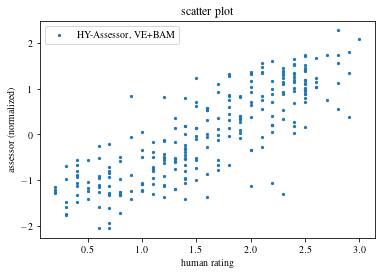

In [210]:
median = np.median(results_dict["ground_truth"])
ground_truth_classification = results_dict["ground_truth"] > median # Classification: larger or smaller than median
target1 = "ve_dmean_weigh"
target2 = "bam_oc"
hy_assessment = (hy_assessor_results-hy_assessor_results.mean())/hy_assessor_results.std()

f, ax1 = plt.subplots()
ax1.scatter(results_dict["ground_truth"], hy_assessment, 5, label=r"HY-Assessor, VE+BAM")

ax1.set_title("scatter plot")
ax1.set_xlabel("human rating")
ax1.set_ylabel("assessor (normalized)")
ax1.legend()
ax1.show

## Supplement: Compute user agreement, Further Analysis

We compute the value of Cohan's Kappa. (https://de.wikipedia.org/wiki/Cohens_Kappa)

First set up the $d_ij$ matrix.
First we compute kappa of the ratings (4 items)

In [223]:
d = 10 # number of raters

In [224]:
dmatrix = data_frame.groupby(['source_file', 'source_id', 'rating_num']).size().unstack(fill_value=0).values
# The dmatrix contains the number of raters, that gave a certain rating for each concept.
print(dmatrix.shape)
print("First lines of dmatrix: \n",dmatrix[:5])

(260, 4)
First lines of dmatrix: 
 [[ 0  0  3  7]
 [ 0  0 10  0]
 [ 0 10  0  0]
 [ 2  5  3  0]
 [ 3  6  1  0]]


In [225]:
pc = np.sum(np.power(dmatrix.sum(axis=0)/dmatrix.sum(),2))

In [226]:
p0 = ((1.0/(d*(d-1.0)))*dmatrix*(dmatrix-1)).sum(axis=1)
p0  = p0.mean()
print("Chance of agreement:", p0)
print("Chance of agreement on random assignment:", pc)
print("Cohens kappa:", (p0-pc)/(1-pc))

Chance of agreement: 0.47008547008547014
Chance of agreement on random assignment: 0.2899440828402367
Cohens kappa: 0.2537002831633349


## Varianance Hypotheses Test

What is the probability that the Variance of the data is observed under the null hypotheses of a uniform distribution?

In [243]:
# Variance for a distrete uniform
var = (4*4-1)/12.0
print(var)
std0 = np.sqrt(var)
print("Variance of discrete uniform:", std0)

1.25
Variance of discrete uniform: 1.118033988749895


In [244]:
dmatrix = data_frame["rating_num"].values
overall_std = np.std(dmatrix.flatten(), ddof=1)
print("Variance of data:", overall_std)

Variance of data: 0.9314136025527721


In [245]:
dmatrix = data_frame[["source_id", "source_file", "rating_num"]].groupby(["source_id", "source_file"]).agg("var").values
dstd = (10/9)*dmatrix
T = (10-1)*(dstd/overall_std)**2

In [246]:
from scipy.stats import chi2
alpha = 0.01
X_value = chi2.ppf(alpha, 9, loc=0, scale=1)
print(X_value)

2.0879007358707273


In [247]:
print(np.sum(T<X_value)/260)

0.5846153846153846


Speak: for 58% of the concepts, the variance of the rating is significantly smaller (p=0.01) than if the values were drawn from a uniform distribution.

### Compute kappa for the agreement on word level. One kappa value is computed for each concept.

In [248]:
dmatrix = data_frame.groupby(['source_file', 'source_id', 'description_idx']).size().unstack(fill_value=0).values
print(dmatrix.shape)
print(dmatrix[:5])

(260, 18)
[[6 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [9 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [6 0 1 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [2 0 0 0 2 0 1 1 0 0 1 3 0 0 0 0 0 0]
 [2 0 5 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0]]


In [249]:
wchoices = data_frame[['source_file', 'source_id','num_word_choices']].drop_duplicates()
num_choices = wchoices['num_word_choices'].values

In [250]:
d = 10 # Number of raters
p0 = ((1.0/(d*(d-1.0)))*dmatrix*(dmatrix-1)).sum(axis=1)
pc = 1.0/num_choices
print("Chance of agreement:", p0.mean())
print("Chance of agreement on random assignment:", pc.mean())
print("Cohens kappa:", (p0.mean()-pc.mean())/(1-pc.mean()))

Chance of agreement: 0.3752991452991453
Chance of agreement on random assignment: 0.10127242572661124
Cohens kappa: 0.30490520978404567


### How do the kappas change for concepts with different average ratings?

In [257]:
local_kappas = (p0-pc)/(1-pc)

In [258]:
by_concept = data_frame.groupby(['source_file', 'source_id']).mean()['rating_num'].reset_index()
by_concept["kappa_agreement"] = local_kappas
print(by_concept)
bins =  np.arange(0, 3, 0.5)
ind = np.digitize(by_concept['rating_num'], bins)
by_concept.groupby(ind).mean()
#res_mat = by_concept[['rating_num','kappa_agreement']].values
#plt.scatter(res_mat[:,0], res_mat[:,1])

          source_file  source_id  rating_num  kappa_agreement
0            awa_Shap          0         2.7         0.377778
1            awa_Shap          1         2.0         0.783333
2            awa_Shap          2         1.0         0.301852
3            awa_Shap          3         1.1         0.012346
4            awa_Shap          4         0.8         0.136508
..                ...        ...         ...              ...
255  places365_mixin5         15         1.5         0.120000
256  places365_mixin5         16         1.3         1.000000
257  places365_mixin5         17         1.4         0.593651
258  places365_mixin5         18         1.1         0.275000
259  places365_mixin5         19         0.9         0.135802

[260 rows x 4 columns]


,source_id,rating_num,kappa_agreement
1,16.157895,0.326316,-0.040414
2,17.650000,0.700000,0.106772
3,14.175439,1.236842,0.269242
4,16.529412,1.698039,0.386514
5,21.034483,2.212069,0.396390
6,25.314286,2.617143,0.504990


Text(0, 0.5, 'kappa')

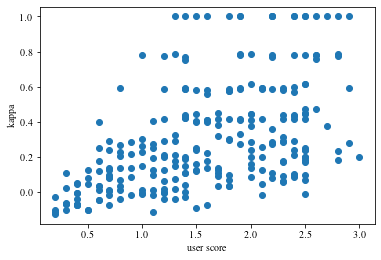

In [259]:
res_mat = by_concept[['rating_num','kappa_agreement']].values
plt.scatter(res_mat[:,0], res_mat[:,1])
plt.xlabel("user score")
plt.ylabel("kappa")